In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import re

In [21]:
arg_component_balance=False
arg_add_transformer=True
arg_add_LLM_TSFM=False
add_all_periods=False

In [22]:
metric = 'mse'
result_path = f'./meta/results'
if arg_add_LLM_TSFM:
    datasets = ['ETTh1', 'ETTh2', 'Exchange', 'ili']
else:
    datasets = ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2', 'ili', 'weather', 'ECL', 'Exchange', 'traffic']

pred_len_1, pred_len_2 = 96, 24
setting = f'component_balance_{arg_component_balance}-add_transformer_{arg_add_transformer}-add_LLM_TSFM_{arg_add_LLM_TSFM}-all_periods_{add_all_periods}'
file_list = [f'{dataset}-{setting}_{pred_len_1}_{pred_len_2}.npz' for dataset in datasets]

# baselines = [
#  'iTransformer',
#  'MambaSimple',
#  'PatchTST',
#  'TimeMixer',
#  'Koopa',
#  'SegRNN',
#  'DLinear',
#  'FEDformer',
#  'Crossformer',
#  'Informer',
#  'PAttn',
#  'ETSformer',
#  'TimeXer',
#  'LightTS',
#  'Nonstationary',
#  'TiDE',
#  'Pyraformer',
#  'MICN',
#  'Transformer',
#  'FiLM',
#  'TimesNet',
#  'TSMixer',
#  'Autoformer',
#  'Reformer',
#  'DUET']
print(len(file_list))

9


In [23]:
# sota performance
def search_sota_performance(dataset, pred_lens=[96],
                            path_old='./results', 
                            path='./results_long_term_forecasting/results'):
    result_dict = {}
    for pred_len in pred_lens:
        model_list_old = os.listdir(path_old)
        model_list_old = [_ for _ in model_list_old if f'pl{pred_len}' in _ and dataset in _]

        try:
            model_list_new = os.listdir(os.path.join(path, dataset))
            model_list_new = [_ for _ in model_list_new if f'pl{pred_len}' in _]
        except:
            model_list_new = []
        model_list = model_list_old + model_list_new

        result_dict[pred_len] = {}
        for model in model_list:
            try:
                result = np.load(os.path.join(path_old, model, 'metrics.npy'), allow_pickle=True)
            except:
                result = np.load(os.path.join(path, dataset, model, 'metrics.npy'), allow_pickle=True)
            result_dict[pred_len][model] = result[0] if metric == 'mae' else result[1]

    df = pd.DataFrame.from_dict(result_dict[pred_lens[0]], orient='index')
    df.columns = [metric]
    df = df.sort_values(by=metric)
    df.index = [_.split('_')[1] if 'LTF' in _ or 'STF' in _ else _.split('_')[6] for _ in df.index]

    return df

In [24]:
dfs_rank = []; dfs_dict = {}
for pred_len_1, pred_len_2 in zip([96, 192, 336, 720], [24, 36, 48, 60]):
    file_list = [f'{dataset}-{setting}_{pred_len_1}_{pred_len_2}.npz' for dataset in datasets]
    dfs = []
    for i, file in enumerate(file_list):
        # dataset = file.split('-')[0]
        dataset = file[:re.search('-component', file).start()]

        if dataset in ['ili', 'covid-19', 'fred-md']:
            df = search_sota_performance(dataset, pred_lens=[pred_len_2])
        else:
            df = search_sota_performance(dataset, pred_lens=[pred_len_1])

        # 添加图例和标题
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']

        df.loc['TSGym'] = top1_perf_epoch[perf_epoch['best_epoch'].item()]
        df.dropna(inplace=True)
        df = df.sort_values(by=metric)
        df = df.reset_index()
        df.columns = ['model', dataset]
        # todo: 有重复, 并且跑出来结果还不同
        df = df.drop_duplicates(subset='model', keep='first')
        df = df.set_index('model')
        dfs.append(df)

    dfs = pd.concat(dfs, axis=1)
    dfs_dict[pred_len_1] = dfs

baselines = pd.concat(list({k: v.rename(columns=lambda col: f"{col}_{k}") for k, v in dfs_dict.items()}.values()), axis=1).dropna().index
baselines = list(baselines)
baselines = [_ for _ in baselines if _ not in ['Transformer', 'DUET']]
print(baselines)

['SegRNN', 'PatchTST', 'TSGym', 'TimeMixer', 'PAttn', 'DLinear', 'FreTS', 'MICN', 'Crossformer', 'TimesNet', 'Autoformer', 'LightTS', 'SCINet', 'TSMixer', 'Mamba', 'Nonstationary', 'Pyraformer']


In [25]:
datasets = ['ETTm1', 'ETTm2', 'ETTh1', 'ETTh2', 'ECL', 'traffic', 'weather', 'Exchange', 'ili']
baselines = ['TSGym', 'TimeMixer', 'TSMixer', 'MICN', 'TimesNet', 'PatchTST', 'DLinear', 'Crossformer', 'Pyraformer', 'Autoformer', 'SegRNN']


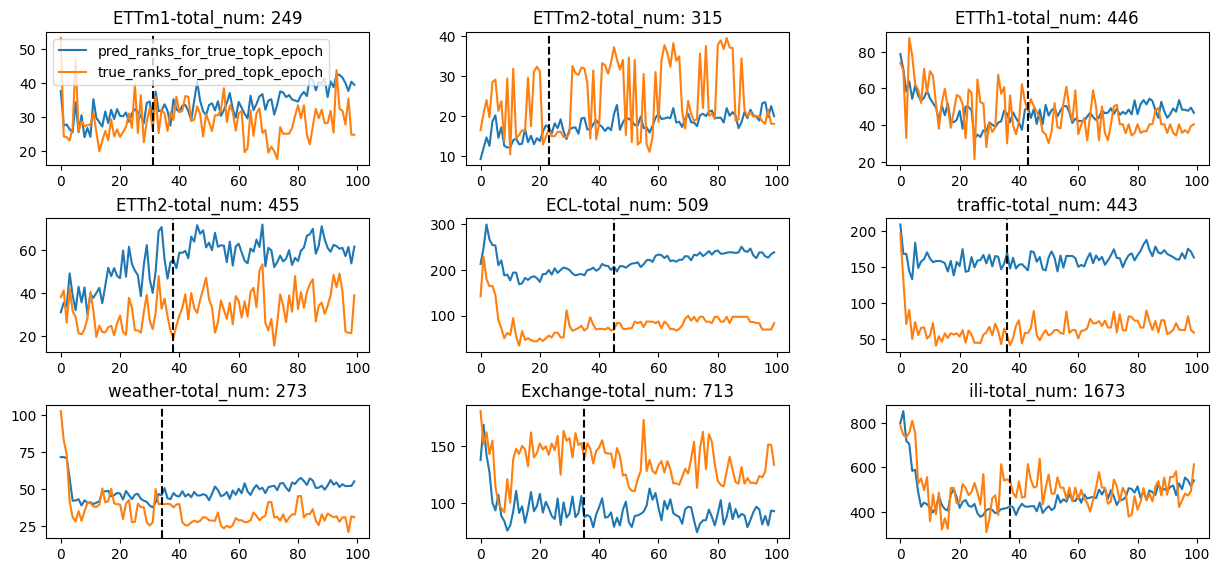

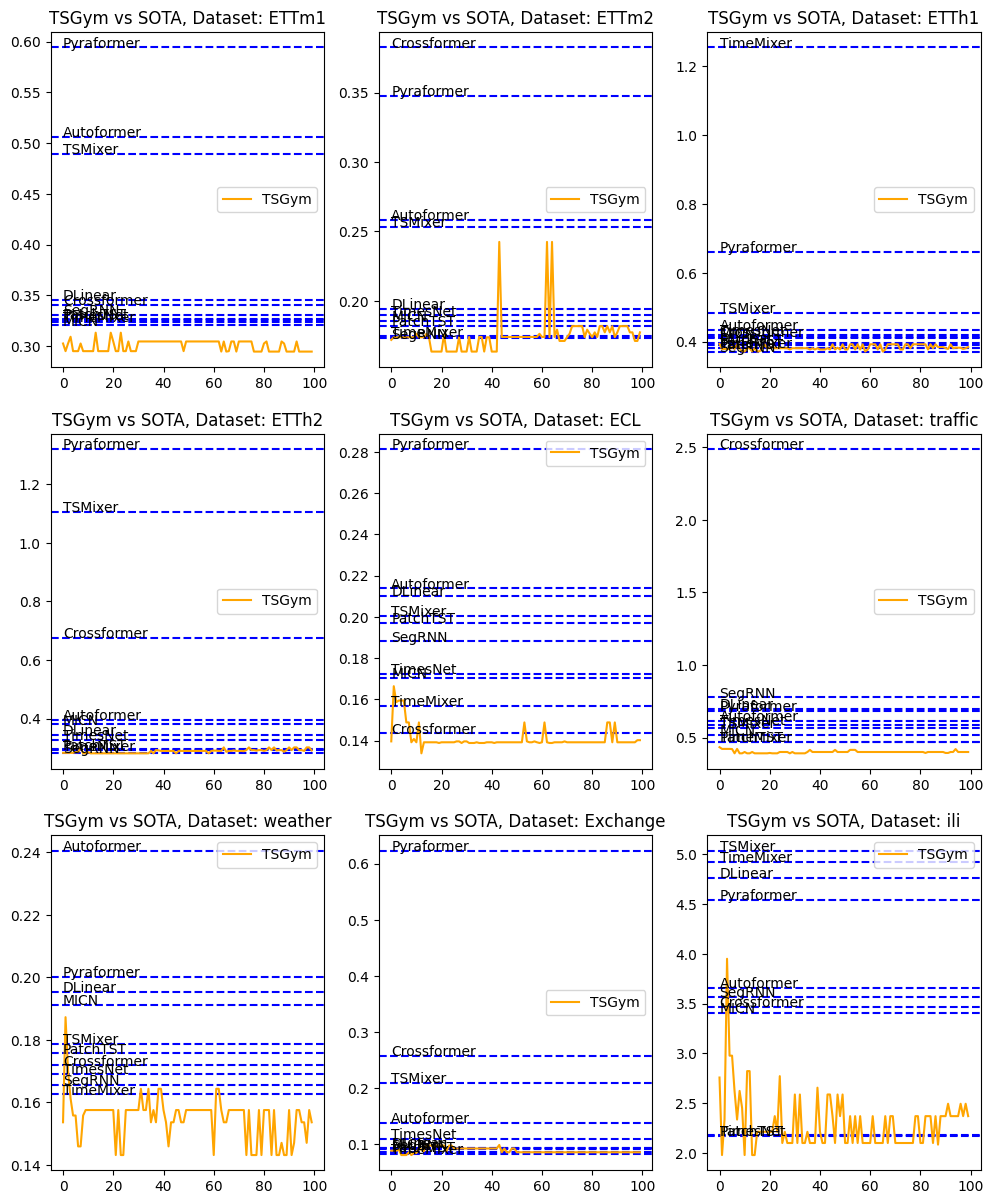

In [27]:
pred_len_1, pred_len_2 = 96, 24
file_list = [f'{dataset}-{setting}_{pred_len_1}_{pred_len_2}.npz' for dataset in datasets]


fig = plt.figure(figsize=(15, 9))
for i, file in enumerate(file_list):
    # perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
    try:
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        # print(perf_epoch.files)

        fig.add_subplot(4, 3, i+1)
        for _ in perf_epoch.files:
            if _ in ['pred_ranks_for_true_topk_epoch', 'true_ranks_for_pred_topk_epoch']:
                plt.plot(perf_epoch[_], label=_)
            elif _ == 'total_num':
                plt.title(f'{file.replace(".npz", "").split("-")[0]}-total_num: {perf_epoch[_]}')
            elif _ == 'best_epoch':
                plt.axvline(perf_epoch['best_epoch'].item(), color='black', linestyle='--')
            else:
                pass 

        if i==0: plt.legend()
    except:
        continue

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

fig = plt.figure(figsize=(12, 20))
for i, file in enumerate(file_list):
    try:
        dataset = file[:re.search('-component', file).start()]
        if dataset in ['ili', 'covid-19', 'fred-md']:
            df = search_sota_performance(dataset, pred_lens=[24])
        else:
            df = search_sota_performance(dataset, pred_lens=[96])
        # except:
        #     continue
        fig.add_subplot(4, 3, i+1)
        for model, m in df.iterrows():
            if model not in baselines: continue
            plt.axhline(y=m.item(), color='blue', linestyle='--')
            plt.text(0, m.item(), model, color='black')

        # 添加图例和标题
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']
        plt.plot(top1_perf_epoch, color='orange', label='TSGym')

        plt.legend()
        plt.title(f'TSGym vs SOTA, Dataset: {dataset}')
    except:
        continue

plt.show()

In [28]:
top1_perf_epoch

array([2.7570233, 1.9777802, 2.3347487, 3.9505124, 2.9767995, 2.9767995,
       2.6184711, 2.3347487, 2.6225944, 2.4507992, 1.9777802, 2.8215506,
       2.8215506, 1.9777802, 1.9777802, 2.211776 , 2.211776 , 2.211776 ,
       2.211776 , 2.211776 , 2.211776 , 2.211776 , 2.3688846, 2.211776 ,
       2.7709312, 2.0989022, 2.211776 , 2.0989022, 2.0989022, 2.0989022,
       2.586549 , 2.0989022, 2.586549 , 2.0989022, 2.0989022, 2.211776 ,
       2.0989022, 2.0989022, 2.0989022, 2.6549673, 2.211776 , 2.0989022,
       2.0989022, 2.586549 , 2.586549 , 2.3688846, 2.0989022, 2.586549 ,
       2.3688846, 2.586549 , 2.0989022, 2.0989022, 2.3688846, 2.0989022,
       2.3688846, 2.0989022, 2.3688846, 2.0989022, 2.0989022, 2.0989022,
       2.0989022, 2.3688846, 2.0989022, 2.0989022, 2.0989022, 2.0989022,
       2.3688846, 2.0989022, 2.3688846, 2.3688846, 2.0989022, 2.0989022,
       2.0989022, 2.0989022, 2.0989022, 2.0989022, 2.0989022, 2.0989022,
       2.3688846, 2.3688846, 2.0989022, 2.0989022, 

In [29]:
# TSGym vs best sota
dfs_rank = []; dfs_dict = {}
for pred_len_1, pred_len_2 in zip([96, 192, 336, 720], [24, 36, 48, 60]):
    file_list = [f'{dataset}-{setting}_{pred_len_1}_{pred_len_2}.npz' for dataset in datasets]
    dfs = []
    for i, file in enumerate(file_list):
        # dataset = file.split('-')[0]
        dataset = file[:re.search('-component', file).start()]

        if dataset in ['ili', 'covid-19', 'fred-md']:
            df = search_sota_performance(dataset, pred_lens=[pred_len_2])
        else:
            df = search_sota_performance(dataset, pred_lens=[pred_len_1])

        # 添加图例和标题
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']

        df.loc['TSGym'] = top1_perf_epoch[perf_epoch['best_epoch'].item()]
        df.dropna(inplace=True)
        df = df.loc[baselines]
        df = df.sort_values(by=metric)
        df = df.reset_index()
        df.columns = ['model', dataset]
        # todo: 有重复, 并且跑出来结果还不同
        df = df.drop_duplicates(subset='model', keep='first')
        df = df.set_index('model')
        dfs.append(df)

    model_names = set.intersection(*map(set, [_.index.tolist() for _ in dfs]))
    for i, df in enumerate(dfs):
        df = df[[_ in model_names for _ in df.index]]
        dfs[i] = df.sort_values(by=df.columns[0])

    ranks = {k: [] for k in baselines}
    ranks['TSGym'] = []
    for df in dfs:
        for baseline in baselines:
            if len(np.where(df.index == baseline)[0]) > 0:
                ranks[baseline].append((np.where(df.index == baseline)[0] + 1).item())
        ranks['TSGym'].append((np.where(df.index == 'TSGym')[0] + 1).item())

    dfs = pd.concat(dfs, axis=1)
    dfs = dfs.round(4)
    dfs.index = dfs.index.str.replace('TemporalFusionTransformer', 'TFT')
    dfs_dict[pred_len_1] = dfs
    # dfs.to_excel(f'./meta/results_paper/perf_component_balance_{arg_component_balance}-add_transformer_{arg_add_transformer}-add_LLM_TSFM_{arg_add_LLM_TSFM}_{pred_len_1}_{pred_len_2}.xlsx', index=True)
    
    df_rank = pd.Series({k: np.mean(v) for k,v in ranks.items() if len(v) > 0})
    df_rank = df_rank.sort_values()
    dfs_rank.append(df_rank)

dfs_rank = pd.concat(dfs_rank, axis=1)
dfs_rank.columns = [str(_) for _ in [96, 192, 336, 720]]
dfs_rank.index = dfs_rank.index.str.replace('TemporalFusionTransformer', 'TFT')
dfs_rank = dfs_rank.round(2)
# dfs_rank.to_excel(f'./meta/results_paper/rank_component_balance_{arg_component_balance}-add_transformer_{arg_add_transformer}-add_LLM_TSFM_{arg_add_LLM_TSFM}.xlsx', index=True)

In [30]:
dfs_dict[96].columns

Index(['ETTm1', 'ETTm2', 'ETTh1', 'ETTh2', 'ECL', 'traffic', 'weather',
       'Exchange', 'ili'],
      dtype='object')

In [31]:
dfs_dict[192]

,ETTm1,ETTm2,ETTh1,ETTh2,ECL,traffic,weather,Exchange,ili
model,,,,,,,,,
TSGym,0.3340,0.2322,0.4050,0.3552,0.1549,0.4336,0.1921,0.2010,2.3017
PatchTST,0.3678,0.2463,0.4302,0.3782,0.1879,0.4721,0.2197,0.1923,2.3992
MICN,0.3685,0.2694,0.5152,0.4964,0.1738,0.5370,0.2376,0.1868,2.6274
TimeMixer,0.3694,0.2398,0.4400,0.3789,0.1688,0.4824,0.2086,0.1741,4.5325
SegRNN,0.3701,0.2360,0.4168,0.3708,0.1988,0.7815,0.2121,0.1842,4.3804
DLinear,0.3816,0.2881,0.4456,0.4824,0.2102,0.6463,0.2375,0.1855,4.4020
Crossformer,0.3820,0.5469,0.4564,0.8650,0.1639,0.6720,0.2141,0.5270,4.7604
TimesNet,0.3821,0.2533,0.4742,0.3918,0.2138,0.6147,0.2274,0.2291,2.2706
TSMixer,0.4744,0.4695,0.5709,2.5688,0.2159,0.5722,0.2142,0.4193,4.9504


In [32]:
dfs_rank

,96,192,336,720
TSGym,1.78,1.67,1.89,2.11
TimeMixer,3.33,3.56,3.33,3.44
PatchTST,3.89,3.67,3.56,4.67
SegRNN,4.22,4.33,4.89,5.67
MICN,5.00,5.67,5.56,5.22
TimesNet,5.33,6.00,6.11,5.22
Crossformer,7.44,7.44,8.11,9.78
DLinear,7.56,6.56,6.44,5.89
TSMixer,8.56,8.56,8.00,7.11
Autoformer,8.78,8.00,7.56,6.67


meta-feature的差异性

In [33]:
# meta_feature_path = '/data/coding/chaochuan/TSGym/meta_learner_cc/meta_feature_copy/meta_feature'

In [34]:
# meta_features_dict = {}
# for file in os.listdir(meta_feature_path):
#     if file.endswith('.npz'):
#         meta_feature = np.load(os.path.join(meta_feature_path, file), allow_pickle=True)
#         meta_features_dict[file.replace('.npz', '').replace('meta_feature_', '')] = meta_feature['meta_feature']

In [35]:
# meta_features = np.stack(list(meta_features_dict.values()))
# meta_features = np.clip(meta_features, -1e4, 1e4)

# # z-score
# mu = np.nanmean(meta_features, axis=0, keepdims=True)
# std = np.nanstd(meta_features, axis=0, keepdims=True)

# meta_features = (meta_features - mu) / (std + 1e-6)
# meta_features = np.nan_to_num(meta_features, nan=0.0)

In [36]:
# fig = plt.figure(figsize=(20, 20))

# for seed in range(1, 5):
#     tsne = TSNE(n_components=2, random_state=seed, perplexity=10)
#     meta_features_tsne = tsne.fit_transform(meta_features) 
#     meta_features_dict_tsne = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_tsne)}
#     fig.add_subplot(2, 2, seed)
#     for k, v in meta_features_dict_tsne.items():
#         plt.scatter(v[0], v[1])
#         plt.text(v[0], v[1], k, fontsize=12)
# fig.suptitle('TSNE', fontsize=16)
# plt.show()


In [37]:
# fig = plt.figure(figsize=(20, 20))

# pca = PCA(n_components=2, random_state=42)
# meta_features_pca = pca.fit_transform(meta_features) 
# meta_features_dict_pca = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_pca)}
# for k, v in meta_features_dict_pca.items():
#     plt.scatter(v[0], v[1])
#     plt.text(v[0], v[1], k, fontsize=16)
# plt.title('PCA', fontsize=16)
# plt.show()
